# Pre-process single-cell methylome data with sincei

This tutorial uses a subset of data from the snmCAT-seq protocol presented in [Luo et. al (2022)](https://www.sciencedirect.com/science/article/pii/S2666979X22000271)

We have pre-processed the dataset to aggregate the methylation counts in 10-kb bins, which we provide on [figshare](https://figshare.com/articles/dataset/snmCAT-seq_testdata_package/26372467).

You can rename the downloaded and unzipped folder to **snmC2Tseq_eckerlab**

The the zip file contains a subfolder named **luo2022_snmCATseq_10kbinned.tgz**, which can be untared and the underlying files can be moved to another subfolder `snmC2Tseq_eckerlab/10k_bin/binned_10kb_all/`.


**NOTES**:
- "unmeth" does not correspond to a proper column, it is the total number of reads per bin. You can check this by observing that the ratio of meth/unmeth maxes out at 0.5.
- If the download command below fails, you may download the data directly from the figshare link above.

In [ ]:
%%bash
# Download and unzip the pre-processed snmCAT-seq 10kb binned data
wget 26372467.zip https://figshare.com/ndownloader/files/26372467
gunzip 26372467.zip
mv 26372467 snmC2Tseq_eckerlab
tar -xvzf snmC2Tseq_eckerlab/luo2022_snmCATseq_10kbinned.tgz

In [1]:
import os, tqdm, math
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

data_type = 'HCGN'

## 1. 10k bin processing

We have pre-processed the data to create a 10k-binned dataset. Here we import the single-sample sets and aggregate them into one dataset.

### Filter by bin coverage

In [4]:
def format_one_sample_depth(f, output_type='GCYN'):
    # output_type: GCYN or HCGN
    df = pd.read_csv(f, sep='\t').set_index('ctxt')
    df = df.loc[output_type].set_index('binID')
    df = df['unmeth']
    df = df.loc[[e for e in df.index if type(e) is str]]
    return ((output_type, f), df)

def format_one_sample_raw(f, output_type='GCYN'):
    # output_type: GCYN or HCGN
    df = pd.read_csv(f, sep='\t').set_index('ctxt')
    df = df.loc[output_type].set_index('binID')
    df = df.loc[[e for e in df.index if type(e) is str]]
    return ((output_type, f), df)

In [5]:
bin_dir = 'snmC2Tseq_eckerlab/binned_10kb_all/'
bin_depth_df = Parallel(n_jobs=8, verbose=0)(
    delayed(format_one_sample_depth)(
        os.path.join(bin_dir, f),
        output_type=data_type
    ) for f in tqdm.tqdm(os.listdir(bin_dir))
)
# formatted_df = pd.concat(dict(itertools.chain(*formatted_df)), axis=1)
bin_depth_df = pd.concat(dict(bin_depth_df), axis=1)
bin_depth_df = bin_depth_df.loc[
    [e for e in bin_depth_df.index if type(e) is str or not math.isnan(e)]
]

100%|███████████████████████████████████████████████████████████████████████████████| 2107/2107 [06:57<00:00,  5.04it/s]


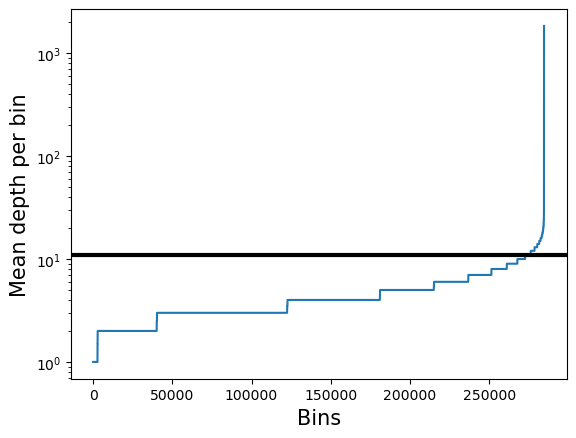

In [7]:
bin_depth_ranking_df = bin_depth_df.median(axis=1).sort_values()
plt.plot(bin_depth_ranking_df.values)
plt.axhline(bin_depth_ranking_df.tail(10000).values[0], linewidth=3, color='black')
plt.ylabel('Mean depth per bin', fontsize=15)
plt.xlabel('Bins', fontsize=15)
plt.yscale('log')

relevant_bins = bin_depth_ranking_df.tail(10000).index
relevant_bins = np.array(relevant_bins).astype(str)
relevant_bins = relevant_bins[relevant_bins != 'nan']

np.savetxt(f"snmC2Tseq_eckerlab/top_bins_{data_type}.txt", relevant_bins.astype(str), fmt='%s')

In [8]:
relevant_bins = np.loadtxt(f"snmC2Tseq_eckerlab/top_bins_{data_type}.txt", dtype=str)

### Import ratio

In [9]:
def format_one_sample_ratio(f, output_type='GCYN', relevant_bins=None):
    # output_type: GCYN or HCGN
    df = pd.read_csv(f, sep='\t').set_index('ctxt')
    df = df.loc[output_type].set_index('binID')
    
    # Keep relevant bins
    if relevant_bins is not None:
        df = df.loc[np.intersect1d(df.index.astype(str), relevant_bins)]
    
    # Recompute ratio (not well computed in the tool, leading to a cap at 0.5).
    df['ratio'] = df['meth'] / df['unmeth']
    df = df['ratio']
    
    df = df.loc[[e for e in df.index if type(e) is str]]
    return ((output_type, f), df)

def format_one_sample_raw(f, output_type='GCYN'):
    # output_type: GCYN or HCGN
    df = pd.read_csv(f, sep='\t').set_index('ctxt')
    df = df.loc[output_type].set_index('binID')
    df = df.loc[[e for e in df.index if type(e) is str]]
    return ((output_type, f), df)

In [10]:
bin_dir = 'snmC2Tseq_eckerlab/binned_10kb_all'
formatted_df = Parallel(n_jobs=8, verbose=0)(
    delayed(format_one_sample_ratio)(
        os.path.join(bin_dir, f), 
        relevant_bins=relevant_bins,
        output_type=data_type
    )
    for f in tqdm.tqdm(os.listdir(bin_dir))
)
# formatted_df = pd.concat(dict(itertools.chain(*formatted_df)), axis=1)
formatted_df = pd.concat(dict(formatted_df), axis=1)
formatted_df = formatted_df.loc[
    [e for e in formatted_df.index if type(e) is str or not math.isnan(e)]
]

100%|███████████████████████████████████████████████████████████████████████████████| 2107/2107 [10:00<00:00,  3.51it/s]


## 2. Restrict ratio to deeply sequenced bins

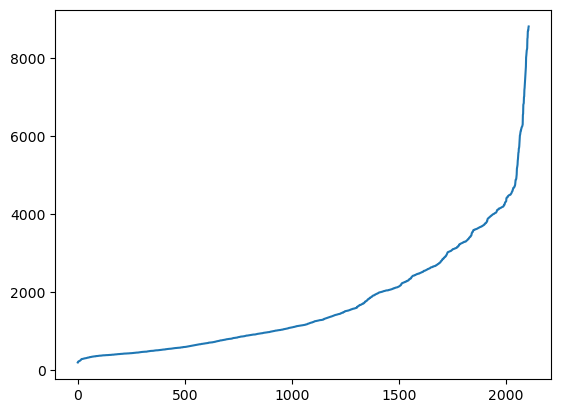

In [11]:
plt.plot(formatted_df.isna().sum(axis=0).sort_values().values)

filtered_formatted_df = formatted_df.loc[:,formatted_df.isna().sum(axis=0) < 4000]

In [12]:
# Mean imputation per row
filtered_formatted_df = filtered_formatted_df.fillna(filtered_formatted_df.mean(axis=0), axis=0)
filtered_formatted_df = filtered_formatted_df.T

In [14]:
filtered_formatted_df.to_csv(f"snmC2Tseq_eckerlab/processed_data_{data_type}_2024_06_13.csv.gz", compression='gzip')